In [2]:
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import psutil
warnings.filterwarnings('ignore') #关闭警告信息
#在notebook中显示动态图像
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
matplotlib.use('WebAgg')

In [3]:
I = 137
UeffVal = 127. #220的相电压有效值
IeffVal = 100
f = 50 #基频
fs = 1200 #采样频率
ts = 1.0/fs #采样时间
omega = 2*np.pi*f #基频 角频率
alpha = 0 #A相初相角 弧度值
Ialpha = alpha-10*np.pi/180
beta = 2*np.pi/3 #B相 初相角
theta = -2*np.pi/3 #C相 初相角
N = 24 # 每20ms采样个数（1200hz采样对对应24个点）

In [1]:
class EeSample():
    def __init__(self):
        self.min_x = 0
        self.max_x = 1
    
    def launchOn(self):
        
        self.fig = plt.figure()
        self.ax =self.fig.add_subplot(111)
        #self.lines, = self.ax.plot([],[],'r-')
        self.ax.set_autoscaley_on(True)
        #self.ax.set_xlim(0,0.05)
        self.ax.grid()
        #self.fig.show()
    
    def sample(self):
        """
        模拟采样过程
        """
        tdata = []
        Usam = []
        Isam = []
        #samPoints = []
        for item,t in enumerate(np.arange(0,0.1,ts)):
            tdata.append(t)
            Usam.append(1.414*UeffVal*np.sin(omega*t+alpha)) 
            Isam.append(1.414*IeffVal*np.sin(omega*t+Ialpha))
        
        return (tdata,Usam,Isam)
    
    def runPlot(self,xdata,a,b,c,x):
        
        self.ax.plot(xdata,a,color='yellow')
        self.ax.plot(xdata,b,color='green')
        self.ax.plot(xdata,c,color='red')
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
        self.ax.set_xlim(left=max(0,x-0.05),right=x+0.05)
        #self.fig.canvas.flush_events()
        #plt.pause(0.01)
    
    def testPlot(self,x,y):
        """
        用于测试
        """
        self.ax.plot(x,y[0],color='b')
        self.ax.relim()
        self.ax.autoscale_view()
        self.ax.set_ylim(-1,20)
        self.fig.canvas.draw()
        return
    
    
    def DiffSample(self):
        """
        差值采样计算
        """
        tdata = []
        ua_sample = []
        ua_eff = []
        ua_tmp = []
        for item,t in enumerate(np.arange(0,0.1,ts)):
            #模拟采样值
            tdata.append(t)
            ua_sample.append(1.414*I*np.sin(omega*t+alpha))
            ua_tmp.append(I)
            
            if  item >= 3:
                
                #t时刻用的是t-1时刻的有效值，有一个ts的延时
                ua_diff_Tpre = (ua_sample[item]-ua_sample[item-2])/2/ts
                ua_Tpre = (ua_sample[item]+ua_sample[item-2])/2
                UaEff = np.sqrt((np.power(ua_Tpre,2)+np.power(ua_diff_Tpre/omega,2))/2)  
                ua_eff.append(UaEff)
            
                self.ax.plot(tdata,ua_tmp,color='b')
                self.ax.plot(tdata[3:],ua_eff,color='r')
                self.fig.canvas.draw()
        return ua_eff
   
    def TriSample(self):
        """
        3点采样法[4u2^2(u2^2-u1*u3)]/[4u2^2-(u1+u3)^2]
        当u2为0时出现计算错误，因而应当避免采样中点为0
        """
        tdata = [] #采样时间点
        xdata = [] #
        ua_sample = [] #电压的采样值
        ua_eff = [] #存储采样的有效值
        ua_tmp = [] #理想的有效值，作为和ua_eff画图对比
        for item,t in enumerate(np.arange(0,0.1,ts)):
            
            #模拟采样值
            tdata.append(t)
            ua_sample.append(1.414*I*np.sin(omega*t+alpha)) #模拟电压采样过程
            ua_tmp.append(I)
            
            if  item >= 3:
                #U2不能为0
                if np.around(ua_sample[item-1]) == 0:
                    continue
                xdata.append(t)
                #t时刻用的是t-1时刻的有效值，有一个单位ts的延时
                fenzi = 4*np.power(ua_sample[item-1],2)*(np.power(ua_sample[item-1],2)-ua_sample[item-2]*ua_sample[item])
                fenmu = 4*np.power(ua_sample[item-1],2)-np.power(ua_sample[item-2]+ua_sample[item],2)
                UaEff = np.sqrt(fenzi/fenmu/2)
                ua_eff.append(UaEff)
                #print("ut is {}".format(ua_sample[item]))
                    
                self.ax.plot(tdata,ua_tmp,color='b')
                self.ax.plot(xdata,ua_eff,color='r')
                self.ax.relim()
                self.ax.autoscale_view()
                self.ax.set_ylim(135,140)
                self.fig.canvas.draw()
        return 
    
    def RIsample(self,u2,u1):
        """
        电压和电流 实部Re 虚部Img 的核心算法
        通过送进来的 n时刻 n-1时刻 实际采样值
        计算出该正弦稳态信号的 实部 和 虚部
        复相量采样
        Re = U(n+1)-U(n)*cos(2*pi/N)
             -----------------------
                    sin(2*pi/N)
        Img = Un
        值得注意的是：实部和虚部 是正弦信号瞬时值的变化
        也就是说，实部和虚部 求出的 模值 是最大值 而非 有效值
        """
        fenzi = u2-u1*np.cos(2*np.pi/N)
        fenmu = np.sin(2*np.pi/N)
        Re = fenzi/fenmu
        Img = u1
        z = np.complex(Re,Img)
        return z
    
    def loadSample(self,u,i):
        """
        通过给定的n时刻电压和电流的复数，求功率和阻抗
        P = 0.5*(Ur*Ir+Ui*Ii)
        Q = 0.5*(Ui*Ir-Ur*Ii)
            Ur*Ir+Ui*Ii
        R = -----------
             Ir^2+Ii^2
             
            Ui*Ir-Ur*Ii
        Q = -----------
             Ir^2+Ii^2
        """
        #功率
        AcPower = 0.5*(u.real*i.real+u.imag*i.imag)
        RePower = 0.5*(u.imag*i.real-u.real*i.imag)
        power = np.complex(AcPower,RePower)
        #阻抗
        Resis = (u.real*i.real+u.imag*i.imag)/(np.power(i.real,2)+np.power(i.imag,2))
        React = (u.imag*i.real-u.real*i.imag)/(np.power(i.real,2)+np.power(i.imag,2))
        imped = np.complex(Resis,React)
        
        return (power,imped)
    
    def ReImSample(self):
        """
        电压和电流 实部Re和虚部Img 求出的模值是最大值，保护算法用时得转换为有效值
        返回值分别为 电压、电流、功率、阻抗的 复数形式
        每一个值代表n时刻 根据电压和电流采样值计算出来的 电压幅值复数、电流幅值复数、功率复数、阻抗复数
        """
        UsamPoints_ReImg = [] #每一个值将是一个复数 代表该时刻电压的实部和虚部
        IsamPoints_ReImg = [] #每一个值将是一个复数 代表该时刻电流的实部和虚部
        powerPoints_ReImg = [] #每一个值将是一个复数 代表该时刻功率的实部和虚部
        impedPoints_ReImg = [] #每一个值将是一个复数 代表该时刻阻抗的实部和虚部
        
        #获取采样数据
        (tdata,U,I) = self.sample()
    
        for index in np.arange(len(tdata)):
            #由于计算值需要两个采样值Un+1 和 Un
            #因此原始采样值(samPoints) 比 计算采样值 (samPoints_ReImg) 
            #多一个数据
            if index > 0:
                #通过采样数据，计算n时刻电压、电流、功率、阻抗的实部和虚部
                UnComplex = self.RIsample(U[index],U[index-1]) #n时刻电压的复数
                InComplex = self.RIsample(I[index],I[index-1]) #n时刻电流的复数
                powerComplex,impedComplex= self.loadSample(UnComplex,InComplex) #n时刻功率和阻抗的复数
                
                UsamPoints_ReImg.append(UnComplex)
                IsamPoints_ReImg.append(InComplex)  
                powerPoints_ReImg.append(powerComplex)
                impedPoints_ReImg.append(impedComplex)
        
        #用于测试
        #y = np.abs(IsamPoints_ReImg)/1.414 #电流有效值
        #phase = np.angle(IsamPoints_ReImg)*180/np.pi
        #y = np.real(powerPoints_ReImg) #有功功率
        #y = np.abs(impedPoints_ReImg)
        #phase = np.angle(impedPoints_ReImg)*180/np.pi
        #self.testPlot(tdata[1:],[phase])
        
        return (UsamPoints_ReImg,IsamPoints_ReImg,powerPoints_ReImg,impedPoints_ReImg) 
   
    
    def app(self):
               
        xdata = []
        ya_data = []
        yb_data = []
        yc_data = []
        for x in np.arange(0,0.2,ts):
            xdata.append(x)
            ya_data.append(1.414*I*np.sin(omega*x+alpha))
            yb_data.append(1.414*I*np.sin(omega*x+beta))
            yc_data.append(1.414*I*np.sin(omega*x+theta))
            self.runPlot(xdata,ya_data,yb_data,yc_data,x)

            time.sleep(0.1)
        return #xdata,ydata

        

<IPython.core.display.Javascript object>


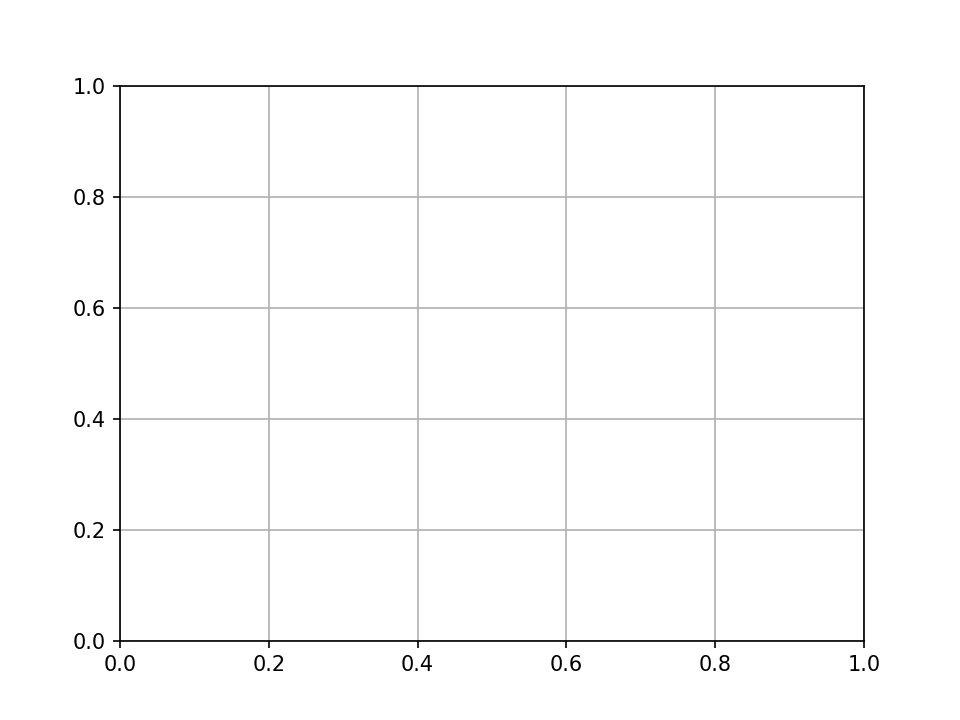

In [41]:
obj = EeSample()
obj.launchOn()

In [42]:
#obj.app()
#obj.TriSample()
x = obj.ReImSample()

In [ ]:
"""
动态画图参考
fig = plt.figure()
ax = fig.add_subplot(111)
plt.show()
i = 0
x,y = [],[]
while True:
    x.append(i)
    y.append(psutil.cpu_percent())
    ax.plot(x,y,color='b')
    fig.canvas.draw()
    ax.set_xlim(left=max(0,i-50),right=i+50)
    time.sleep(0.1)
    i += 1

"""


"""
Ia = 1.414*I*np.sin(omega*t+alpha)
Ib = 1.414*I*np.sin(omega*t+beta)
Ic = 1.414*I*np.sin(omega*t+theta)
t = np.arange(0,2,ts)
plt.plot(t,Ia,t,Ib,t,Ic)
plt.xlim(0,0.05)
plt.show()

"""